In [9]:
import io
import uuid
from xml.etree import ElementTree
import requests
import scipy.stats as st
from matplotlib import colors
import matplotlib
import numpy as np
import pandas as pd
import datetime
import statistics
import csv
import matplotlib.gridspec as gridspec
from pathlib import Path
import statistics
from rdflib import Graph, ConjunctiveGraph, Namespace, OWL, Literal, URIRef, BNode, XSD, RDFS, RDF
from SPARQLWrapper import SPARQLWrapper, JSON
import networkx as nx
import networkx.algorithms.community as nx_comm
from cdlib import algorithms
import matplotlib.pyplot as plt
from cdlib import evaluation
from cdlib import TemporalClustering
from cdlib.algorithms import louvain
from cdlib import algorithms, viz
from src import hintohg
from src import dynamic_cd
from src import cd
from src import attributes
from src import description
from src import vizualisation
from collections import Counter
import pickle

<h1>Defining metapath queries</h1>

In [10]:
# Illustrator - Book - Illustrator
BIB = """PREFIX sem: <http://semanticweb.cs.vu.nl/2009/11/sem/>
        PREFIX xsd:  <http://www.w3.org/2001/XMLSchema#> 
        PREFIX schema: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        SELECT * WHERE {
           GRAPH <https://data.goldenagents.org/datasets/u692bc364e9d7fa97b3510c6c0c8f2bb9a0e5123b/processes_of_creativity_20220128> {

            ?b a schema:Book ;
                schema:illustrator ?w1, ?w2 ;
                schema:publication ?publicationEvent .

            ?publicationEvent a schema:PublicationEvent .

            OPTIONAL { ?publicationEvent sem:hasEarliestBeginTimeStamp ?bt} .

            OPTIONAL { ?publicationEvent sem:hasLatestEndTimeStamp ?et} .

            FILTER(?w1 != ?w2)
            FILTER(STR(?w1) < STR(?w2))
            }
        }"""
# Contributor - Book - Contributor
BCB = """PREFIX sem: <http://semanticweb.cs.vu.nl/2009/11/sem/>
        PREFIX xsd:  <http://www.w3.org/2001/XMLSchema#> 
        PREFIX schema: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        SELECT * WHERE {
                GRAPH <https://data.goldenagents.org/datasets/u692bc364e9d7fa97b3510c6c0c8f2bb9a0e5123b/processes_of_creativity_20220128> {
                        
                        ?b schema:contributor ?w1, ?w2 ;
                                schema:publication ?publicationEvent .
                        
                        # Iets expliciet maken helpt altijd voor de query-processor.
                        ?publicationEvent a schema:PublicationEvent .
                        
                        OPTIONAL { ?publicationEvent sem:hasEarliestBeginTimeStamp ?bt}. 
                        OPTIONAL { ?publicationEvent sem:hasLatestEndTimeStamp ?et}.
                        
                        FILTER(?w1 != ?w2).
                        FILTER(STR(?w1) < STR(?w2))
                }
        }"""
# Contributor/Illustrator/Publisher - Book - Contributor/Illustrator/Publisher
BCPIB = """PREFIX sem: <http://semanticweb.cs.vu.nl/2009/11/sem/>
                PREFIX xsd:  <http://www.w3.org/2001/XMLSchema#> 
                PREFIX schema: <http://schema.org/>
                PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
                PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
                SELECT * WHERE {
                
                GRAPH <https://data.goldenagents.org/datasets/u692bc364e9d7fa97b3510c6c0c8f2bb9a0e5123b/processes_of_creativity_20220128> {

                ?b schema:illustrator|schema:contributor|schema:publication/schema:publishedBy ?w1, ?w2 ;
                        schema:publication ?publicationEvent .
                
                # Iets expliciet maken helpt altijd voor de query-processor.
                ?publicationEvent a schema:PublicationEvent .
                
                OPTIONAL { ?publicationEvent sem:hasEarliestBeginTimeStamp ?bt}. # Typo in de STCN
                OPTIONAL { ?publicationEvent sem:hasLatestEndTimeStamp ?et}.
                # OPTIONAL { ?bt a ?type}.  # Typo in de STCN
                
                FILTER(?w1 != ?w2)
                FILTER(STR(?w1) < STR(?w2))
}}"""


metapaths = { "BIB" : BIB,
              "BCB" : BCB,
              "BCPIB" : BCPIB,
            }

<h1>Importing the graph based on selected metapath</h1>

Dataframes imported
HG imported


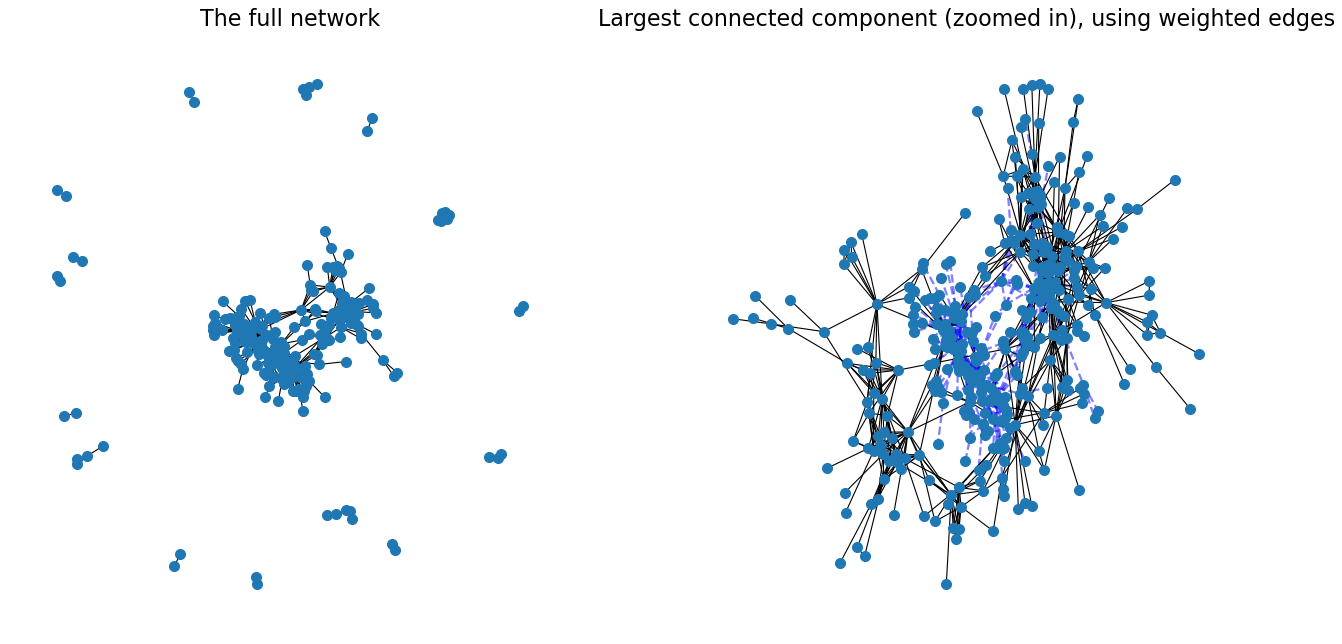

In [11]:
selected_metapath = "BIB"

(df, names_df, attributes_df, hg) = hintohg.init_data(selected_metapath, metapaths)
vizualisation.draw_hg(hg)

<h1>Creating snapshot graph and performing dynamic community detection</h1>

In [12]:
interval = 20
shift = 10
theta = 0.3

snapshot_graph = dynamic_cd.create_snapshot_graph(hg, interval, shift, names_df)
(dcd_results_init_partition, tc, snapshots, snapshot_times) = dynamic_cd.execute_dcd(snapshot_graph, f"{interval}_{shift}")
# dynamic_coms, com_events = dynamic_cd.matching(tc, theta)

df_folder = Path("./data/dynamic_coms")
# with open(df_folder / (selected_metapath + "_tc.pickle"), 'wb') as handle:
#     pickle.dump(tc, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(df_folder / (selected_metapath + "_dynamic_coms.pickle"), 'wb') as handle:
#     pickle.dump(dynamic_coms, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(df_folder / (selected_metapath + "_com_events.pickle"), 'wb') as handle:
#     pickle.dump(com_events, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(df_folder / (selected_metapath + "_dynamic_coms.pickle"), 'rb') as handle:
    dynamic_coms = pickle.load(handle)
with open(df_folder / (selected_metapath + "_tc.pickle"), 'rb') as handle:
    tc = pickle.load(handle)
with open(df_folder / (selected_metapath + "_com_events.pickle"), 'rb') as handle:
    com_events = pickle.load(handle)

Interval: 20, Stepsize: 10
Num of snapshots: 27
Handling sg with parameters: 20_10


<h1>RESULTS: follow a person through time, edit "name"</h1>

NAME TO FIND: Zacharias Webber

TIMESTEP: 11
DYNAMIC COMMUNITY: 22
INTERVAL (1647, 1667)


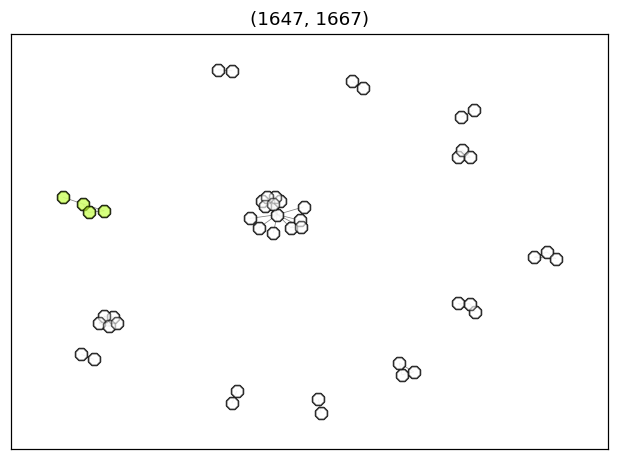

Jan Jansz. Veenhuysen - Centrality: 0.065 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/7602
Zacharias Webber - Centrality: 0.043 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/8177
Abraham Blooteling - Centrality: 0.043 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/1061
Jacob Willems van Meurs - Centrality: 0.022 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/5223
---------------------------------------------------------------
TIMESTEP: 12
DYNAMIC COMMUNITY: 22
INTERVAL (1657, 1677)


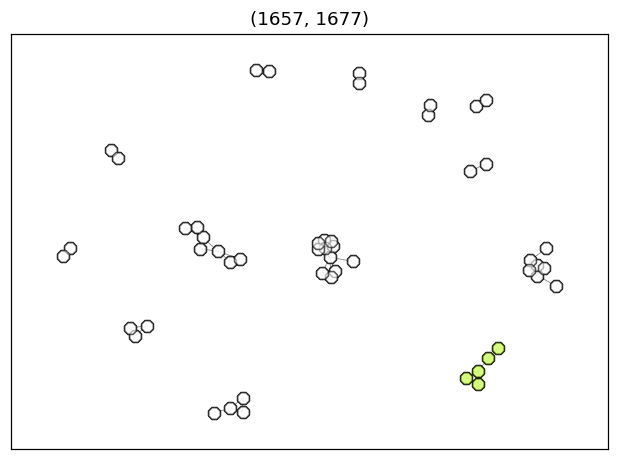

Jan Jansz. Veenhuysen - Centrality: 0.06 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/7602
Zacharias Webber - Centrality: 0.04 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/8177
Jacob Willems van Meurs - Centrality: 0.04 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/5223
Abraham Blooteling - Centrality: 0.04 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/1061
Arnoldus Montanus - Centrality: 0.02 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/53229
---------------------------------------------------------------
TIMESTEP: 13
DYNAMIC COMMUNITY: 35
INTERVAL (1667, 1687)


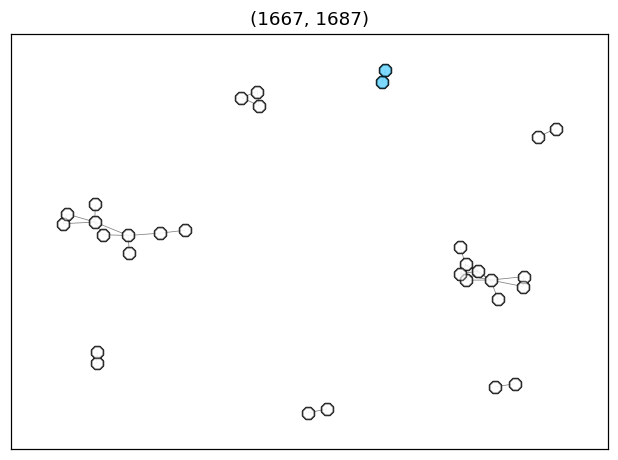

Zacharias Webber - Centrality: 0.033 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/8177
Jan Jansz. Veenhuysen - Centrality: 0.033 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/7602

COMMUNITY WAS SPLIT FROM: 22
#############################################
Jan Jansz. Veenhuysen - Centrality: 0.06 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/7602
Zacharias Webber - Centrality: 0.04 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/8177
Jacob Willems van Meurs - Centrality: 0.04 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/5223
Abraham Blooteling - Centrality: 0.04 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/1061
Arnoldus Montanus - Centrality: 0.02 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/53229
#############################################

INTO THIS COMMUNITY AND:  22
#############################################
Jacob Willems van Meurs - Centrality: 0.033 - URI: http://www.vondel.human

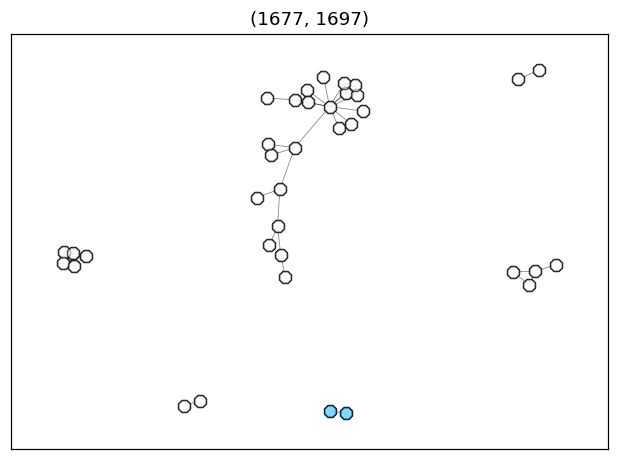

Zacharias Webber - Centrality: 0.028 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/8177
Jan Jansz. Veenhuysen - Centrality: 0.028 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/7602
---------------------------------------------------------------
TIMESTEP: 16
DYNAMIC COMMUNITY: 35
INTERVAL (1697, 1717)


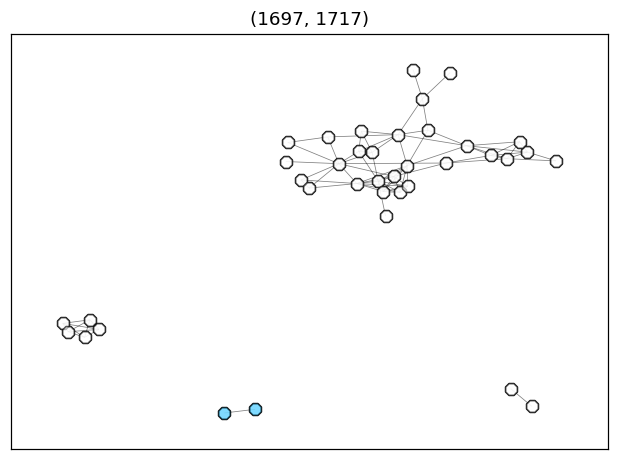

Zacharias Webber - Centrality: 0.027 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/8177
Jan Jansz. Veenhuysen - Centrality: 0.027 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/7602
---------------------------------------------------------------
TIMESTEP: 17
DYNAMIC COMMUNITY: 35
INTERVAL (1707, 1727)


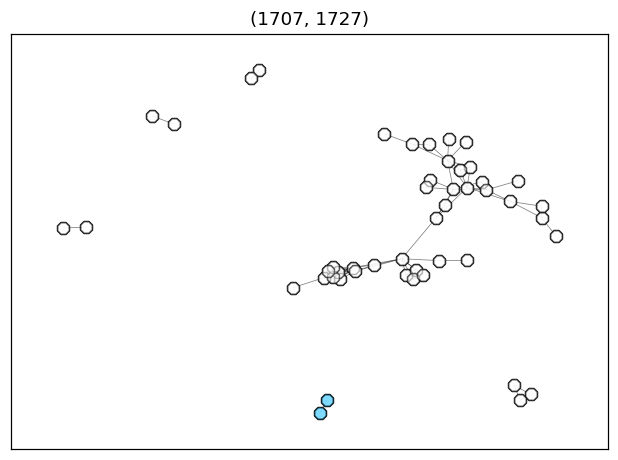

Zacharias Webber - Centrality: 0.021 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/8177
Jan Jansz. Veenhuysen - Centrality: 0.021 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/7602
---------------------------------------------------------------
TIMESTEP: 19
DYNAMIC COMMUNITY: 35
INTERVAL (1727, 1747)


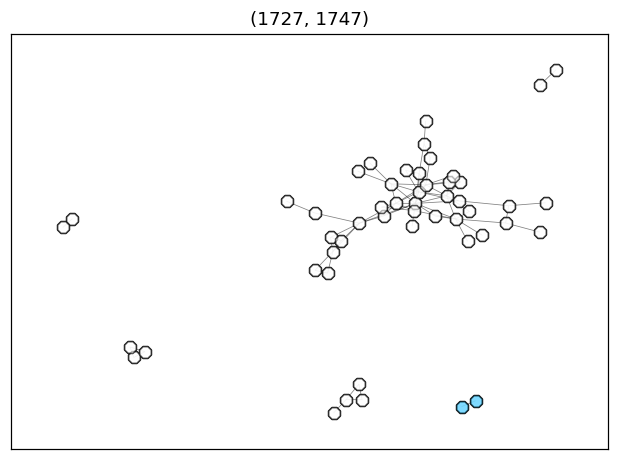

Zacharias Webber - Centrality: 0.02 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/8177
Jan Jansz. Veenhuysen - Centrality: 0.02 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/7602
---------------------------------------------------------------
TIMESTEP: 20
DYNAMIC COMMUNITY: 35
INTERVAL (1737, 1757)


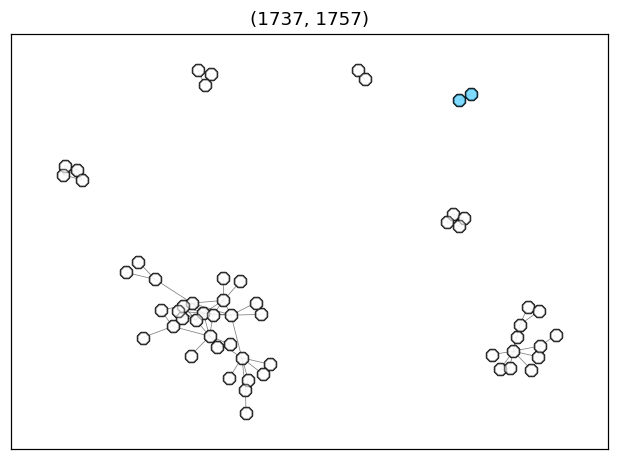

Zacharias Webber - Centrality: 0.018 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/8177
Jan Jansz. Veenhuysen - Centrality: 0.018 - URI:http://www.vondel.humanities.uva.nl/ecartico/persons/7602
---------------------------------------------------------------


In [13]:
# EDIT THIS
name = "Zacharias Webber"

res = dynamic_cd.find_dyn_com(dynamic_coms, name, tc, snapshots, snapshot_times, names_df, com_events)

<h1>RESULTS: follow a dynamic community based on the dynamic community id, edit "dyn_com_id"</h1>

Timestep: 11, Period: (1647, 1667)


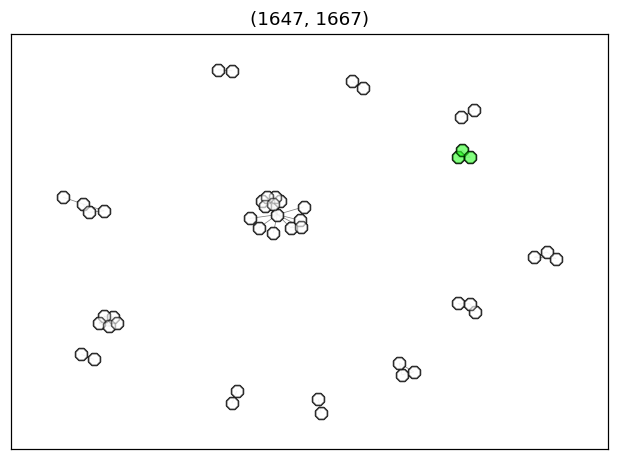

Pieter Nolpe - Centrality: 0.043 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/5662
Pieter Jansz Post - Centrality: 0.043 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/6106
Jan Mathysz - Centrality: 0.043 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/57213
---------------------------------------------------------------
Timestep: 12, Period: (1657, 1677)


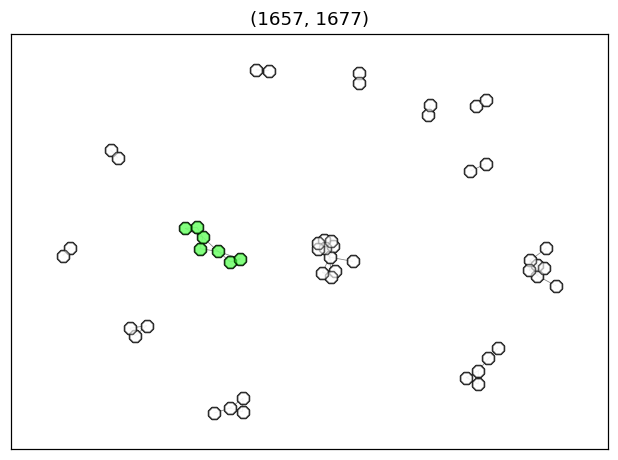

Philips Davidsz Vingboons - Centrality: 0.08 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/7873
Jan Mathysz - Centrality: 0.08 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/57213
Pieter Nolpe - Centrality: 0.04 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/5662
Pieter Jansz Post - Centrality: 0.04 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/6106
Jacob van Campen - Centrality: 0.04 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/1616
Jacob Vennekool - Centrality: 0.04 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/7660
Bastiaen Stopendael - Centrality: 0.04 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/7169

MERGED WITH:
24
#############################################
Philips Davidsz Vingboons - Centrality: 0.043 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/7873
Jacob van Campen - Centrality: 0.043 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/1616
Jacob Venneko

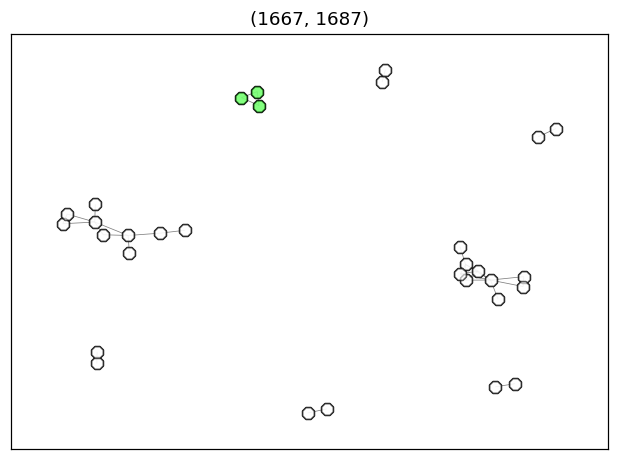

Philips Davidsz Vingboons - Centrality: 0.067 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/7873
Jan Mathysz - Centrality: 0.067 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/57213
Bastiaen Stopendael - Centrality: 0.067 - URI: http://www.vondel.humanities.uva.nl/ecartico/persons/7169
---------------------------------------------------------------


In [14]:
# EDIT THIS
dynamic_com_id = 23

dynamic_cd.print_dyn_com(dynamic_coms, dynamic_com_id, tc, snapshots, snapshot_times, names_df, com_events)

<h1>RESULTS: produce a description of a dynamic community, edit "dyn_com_id"</h1>

In [15]:
union_com = dynamic_cd.get_community_union(tc, snapshots, snapshot_times, dynamic_coms, dynamic_com_id)
print(f"Number of people in the community: {len(union_com)}")
description.get_community_description(union_com, attributes_df)

Number of people in the community: 13


{'Birthplace': ('Amsterdam', 66.67),
 'Religion': ('Reformed', 43.02),
 'Occupation': (' fine art painter', 18.52),
 'Occupational Address': ('Amsterdam', 50.0),
 'Family Relation': (' Engelbert Nolpe', 5.71),
 'Birthday': 1620}